In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd '/content/drive/MyDrive/responsive-ai'

/content/drive/MyDrive/responsive-ai


## Dependencies

In [ ]:
!pip install fairlearn
!pip install quantus
!pip install captum==0.7.0
!pip install ptflops
!pip install rtdl_revisiting_models

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from fairlearn.datasets import fetch_diabetes_hospital
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import shap
import quantus
import pickle
from tqdm import tqdm
import time

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-e2f12ffc424c>", line 1, in <cell line: 0>
    import torch
  File "<frozen importlib._bootstrap>", line 1176, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1138, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 1078, in _find_spec
  File "<frozen importlib._bootstrap_external>", line 1507, in find_spec
  File "<frozen importlib._bootstrap_external>", line 1476, in _get_spec
  File "<frozen importlib._bootstrap_external>", line 1434, in _path_importer_cache
OSError: [Errno 107] Transport endpoint is not connected

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    st

# Data

## Loading

In [ ]:
X, y = fetch_diabetes_hospital(as_frame=True, return_X_y=True)
# The columns readmit_binary and readmitted are included in X -> remove both to avoid target leakage
X.drop(columns=["readmitted", "readmit_binary"], inplace=True)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-a138939f2e8d>", line 1, in <cell line: 0>
    X, y = fetch_diabetes_hospital(as_frame=True, return_X_y=True)
           ^^^^^^^^^^^^^^^^^^^^^^^
NameError: name 'fetch_diabetes_hospital' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
          ^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/ultratb.py", line 1101, in get_records
    return _f

In [ ]:
# Get a boolean mask for rows where gender is not 'Unknown/Invalid' (which was encoded as 2)
valid_gender_mask = X['gender'] != 'Unknown/Invalid'

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-6a61a850cb8f>", line 2, in <cell line: 0>
    valid_gender_mask = X['gender'] != 'Unknown/Invalid'
                        ^
NameError: name 'X' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
          ^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_

In [ ]:
# Filter both X and y using the same mask
X = X[valid_gender_mask]
y = y[valid_gender_mask]

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-d73847af4c97>", line 2, in <cell line: 0>
    X = X[valid_gender_mask]
        ^
NameError: name 'X' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
          ^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
           ^^^^^^^^^^

## Preprocessing

In [ ]:
X_enc = X.copy()
cat_cols = X_enc.select_dtypes(['object','category']).columns
cardinalities = []
label_mappings = {}
for col in cat_cols:
    le = LabelEncoder()
    X_enc[col] = le.fit_transform(X_enc[col])
    cardinalities.append(len(le.classes_))
    label_mappings[col] = dict(zip(le.classes_, le.transform(le.classes_)))

num_cols = [c for c in X_enc.columns if c not in cat_cols]

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-458c2f4f00e8>", line 1, in <cell line: 0>
    X_enc = X.copy()
            ^
NameError: name 'X' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
          ^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
           ^^^^^^^^^^^^^^

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-458c2f4f00e8>", line 1, in <cell line: 0>
    X_enc = X.copy()
            ^
NameError: name 'X' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
          ^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
        ^^^^^^^^^^^^^^^^^^^^^^^^^^

In [ ]:
for col, mapping in label_mappings.items():
    print(f"\nEncoded mapping for '{col}':")
    for original, encoded in mapping.items():
        print(f"  {original} → {encoded}")

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-cf84e23c5dab>", line 1, in <cell line: 0>
    for col, mapping in label_mappings.items():
                        ^^^^^^^^^^^^^^
NameError: name 'label_mappings' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
          ^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb,

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-cf84e23c5dab>", line 1, in <cell line: 0>
    for col, mapping in label_mappings.items():
                        ^^^^^^^^^^^^^^
NameError: name 'label_mappings' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
          ^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes
    if (await self.run_cod

In [ ]:
print(f"\nCardinalities of categorical columns: {cardinalities}")

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-1ae7357117da>", line 1, in <cell line: 0>
    print(f"\nCardinalities of categorical columns: {cardinalities}")
                                                     ^^^^^^^^^^^^^
NameError: name 'cardinalities' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
          ^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/ultratb.py", line 1101, in 

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-1ae7357117da>", line 1, in <cell line: 0>
    print(f"\nCardinalities of categorical columns: {cardinalities}")
                                                     ^^^^^^^^^^^^^
NameError: name 'cardinalities' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
          ^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 

## Splitting and Formatting

In [ ]:
# Train/test split
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X_enc, y, test_size=0.2, random_state=7, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.2, random_state=7, stratify=y_trainval
)

# Convert to numpy / tensors
X_train_num = X_train[num_cols].to_numpy(dtype=np.float32)
X_val_num   = X_val[num_cols].to_numpy(dtype=np.float32)
X_test_num  = X_test[num_cols].to_numpy(dtype=np.float32)

X_train_cat = X_train[cat_cols].to_numpy(dtype=np.int64)
X_val_cat   = X_val[cat_cols].to_numpy(dtype=np.int64)
X_test_cat  = X_test[cat_cols].to_numpy(dtype=np.int64)

y_train_np = y_train.astype(np.int64).values if isinstance(y_train, pd.Series) else y_train.astype(np.int64)
y_val_np   = y_val.astype(np.int64).values if isinstance(y_val, pd.Series) else y_val.astype(np.int64)
y_test_np = y_test.astype(np.int64).values if isinstance(y_test, pd.Series) else y_test.astype(np.int64)

y_train_t = torch.from_numpy(y_train_np).long()
y_val_t   = torch.from_numpy(y_val_np).long()
y_test_t  = torch.from_numpy(y_test_np).long()


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-dbd2c43d8ddd>", line 2, in <cell line: 0>
    X_trainval, X_test, y_trainval, y_test = train_test_split(
                                             ^^^^^^^^^^^^^^^^
NameError: name 'train_test_split' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
          ^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/ultratb.py", line 1101, in get_recor

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-dbd2c43d8ddd>", line 2, in <cell line: 0>
    X_trainval, X_test, y_trainval, y_test = train_test_split(
                                             ^^^^^^^^^^^^^^^^
NameError: name 'train_test_split' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
          ^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3473, in 

## Dataloaders

In [ ]:
batch_size = 32
train_ds = TensorDataset(
    torch.from_numpy(X_train_num),
    torch.from_numpy(X_train_cat),
    y_train_t
)
val_ds = TensorDataset(
    torch.from_numpy(X_val_num),
    torch.from_numpy(X_val_cat),
    y_val_t
)
test_ds = TensorDataset(
    torch.from_numpy(X_test_num),
    torch.from_numpy(X_test_cat),
    y_test_t
)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-3e9f7878bfae>", line 2, in <cell line: 0>
    train_ds = TensorDataset(
               ^^^^^^^^^^^^^
NameError: name 'TensorDataset' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
          ^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, 

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-3e9f7878bfae>", line 2, in <cell line: 0>
    train_ds = TensorDataset(
               ^^^^^^^^^^^^^
NameError: name 'TensorDataset' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
          ^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy))

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-3e9f7878bfae>", line 2, in <cell line: 0>
    train_ds = TensorDataset(
               ^^^^^^^^^^^^^
NameError: name 'TensorDataset' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
          ^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy))

# FTTransformer model

In [ ]:
from rtdl_revisiting_models import FTTransformer

# Input dims
d_num = X_train_num.shape[1]
cat_cardinalities = cardinalities
n_cont_features = len(num_cols)
d_out = 2

default_kwargs = FTTransformer.get_default_kwargs()
# default_kwargs['n_blocks'] = 2
default_kwargs['d_block'] = 32
default_kwargs['attention_n_heads'] = 1
# default_kwargs['attention_dropout'] = 0.2   # originally ~0.1
# default_kwargs['ffn_dropout']       = 0.2   # originally ~0.1
# default_kwargs['residual_dropout']  = 0.2   # originally 0.0 or tiny

model = FTTransformer(
    n_cont_features=n_cont_features,
    cat_cardinalities=cat_cardinalities,
    d_out=d_out,
    **default_kwargs,
)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-125ecb3d918a>", line 1, in <cell line: 0>
    from rtdl_revisiting_models import FTTransformer
  File "<frozen importlib._bootstrap>", line 1176, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1138, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 1078, in _find_spec
  File "<frozen importlib._bootstrap_external>", line 1507, in find_spec
  File "<frozen importlib._bootstrap_external>", line 1476, in _get_spec
  File "<frozen importlib._bootstrap_external>", line 1434, in _path_importer_cache
OSError: [Errno 107] Transport endpoint is not connected

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py"

# Training & Eval

## Training

In [ ]:
best_val_loss = float('inf')
best_epoch    = -1
patience   = 20
epochs_no_improve = 0
best_state_dict = None
num_epochs = 100

start_time = time.time()
for epoch in range(1, num_epochs+1):
    # ---- training step ----
    model.train()
    total_loss = 0
    all_preds, all_targets = [], []

    for Xn, Xc, yb in tqdm(train_loader, desc=f"Epoch {epoch:02d} [Train]", leave=False):
        Xn, Xc, yb = Xn.to(device), Xc.to(device), yb.to(device)
        logits = model(Xn, Xc)                    # (batch_size, 2)
        loss = criterion(logits, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * Xn.size(0)
        preds = logits.argmax(dim=1).cpu().numpy()
        all_preds.append(preds)
        all_targets.append(yb.cpu().numpy())

    # Epoch metrics
    train_loss = total_loss / len(train_loader.dataset)
    train_acc  = accuracy_score(
        np.concatenate(all_targets), np.concatenate(all_preds)
    )

    # ---- validation step ----
    model.eval()
    total_val_loss = 0.0
    all_val_preds, all_val_targs = [], []
    with torch.no_grad():
        for Xn_val, Xc_val, yb_val in tqdm(val_loader, desc=f"Epoch {epoch:02d} [Validate]", leave=False):
            Xn_val = Xn_val.to(device)
            Xc_val = Xc_val.to(device)
            yb_val = yb_val.to(device)

            logits_val = model(Xn_val, Xc_val)
            loss_val = criterion(logits_val, yb_val)

            total_val_loss += loss_val.item() * Xn_val.size(0)
            preds_val = logits_val.argmax(dim=1).cpu().numpy()
            all_val_preds.append(preds_val)
            all_val_targs.append(yb_val.cpu().numpy())

    val_loss = total_val_loss / len(val_loader.dataset)
    val_acc  = accuracy_score(np.concatenate(all_val_targs), np.concatenate(all_val_preds))

    if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch {epoch:02d}  Loss: {train_loss:.4f}  Train Acc: {train_acc:.4f}  Val Acc: {val_acc:.4f}")

    # ---- check for improvement ----
    if val_loss < best_val_loss - 1e-5:
        best_val_loss = val_loss
        best_epoch = epoch
        epochs_no_improve = 0
        best_state_dict = model.state_dict()  # save best weights
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"\nEarly stopping triggered! No improvement in {patience} epochs.")
            break

end_time = time.time()
elapsed_time = end_time - start_time
print("\nTotal training time: ", elapsed_time)

if best_state_dict is not None:
    model.load_state_dict(best_state_dict)

Epoch 01  Loss: 0.3463  Train Acc: 0.8874  Val Acc: 0.8884


Epoch 10  Loss: 0.3395  Train Acc: 0.8884  Val Acc: 0.8884


Epoch 20  Loss: 0.3385  Train Acc: 0.8884  Val Acc: 0.8884


Epoch 30  Loss: 0.3375  Train Acc: 0.8884  Val Acc: 0.8884


Epoch 40  Loss: 0.3370  Train Acc: 0.8884  Val Acc: 0.8884


Epoch 50  Loss: 0.3368  Train Acc: 0.8884  Val Acc: 0.8884



Early stopping triggered! No improvement in 20 epochs.

Total training time:  1600.6846225261688


## Eval

In [ ]:
# Loading the model
model.load_state_dict(torch.load("saved_model/fttransformer_diabetes.pth"))

<All keys matched successfully>

In [ ]:
# 6. Evaluation on Test Set
model.eval()
test_preds, test_targets = [], []
with torch.no_grad():
    for Xn, Xc, yb in tqdm(test_loader, desc="Testing", leave=False):
        Xn, Xc = Xn.to(device), Xc.to(device)
        logits = model(Xn, Xc)
        test_preds.append(logits.argmax(dim=1).cpu().numpy())
        test_targets.append(yb.numpy())

test_acc = accuracy_score(
    np.concatenate(test_targets),
    np.concatenate(test_preds)
)
print(f"FT-Transformer Test Accuracy: {test_acc:.4f}")


FT-Transformer Test Accuracy: 0.8884


In [ ]:
# Saving the model
torch.save(model.state_dict(), "saved_model/fttransformer_diabetes.pth")

# Explainability

## SHAP

In [ ]:
X_test_combined = np.hstack([X_test_num, X_test_cat])  # shape (n_test, n_cont + n_cat)
y_test_int = y_test_np.astype(np.int64)

n_cont = X_test_num.shape[1]
n_cat  = X_test_cat.shape[1]
background = X_test_combined[:100]

In [ ]:
def f_shap(combined_X):
    """
    combined_X has shape (batch_size, n_cont + n_cat).
    We split it into numeric vs. categorical, convert to torch, pass through FTTransformer,
    and return P(class=1) as a 1D numpy array of length batch_size.
    """
    model.eval()
    # split
    X_num_np = combined_X[:, :n_cont].astype(np.float32)
    X_cat_np = combined_X[:, n_cont:].astype(np.int64)

    with torch.no_grad():
        Xn = torch.from_numpy(X_num_np).to(device)
        Xc = torch.from_numpy(X_cat_np).to(device)
        logits = model(Xn, Xc)                  # shape (batch_size, 2)
        probs = torch.softmax(logits, dim=1).cpu().numpy()
    return probs[:, 1]  # P(class=1)

In [ ]:
explainer = shap.KernelExplainer(f_shap, background)

In [ ]:
with open('saved_shap/fttransformer_shap_values_diabetes.pkl', 'rb') as f:
    shap_values = pickle.load(f)

In [ ]:
shap_values = explainer.shap_values(X_test_combined, nsamples=100)

  0%|          | 0/20353 [00:00<?, ?it/s]

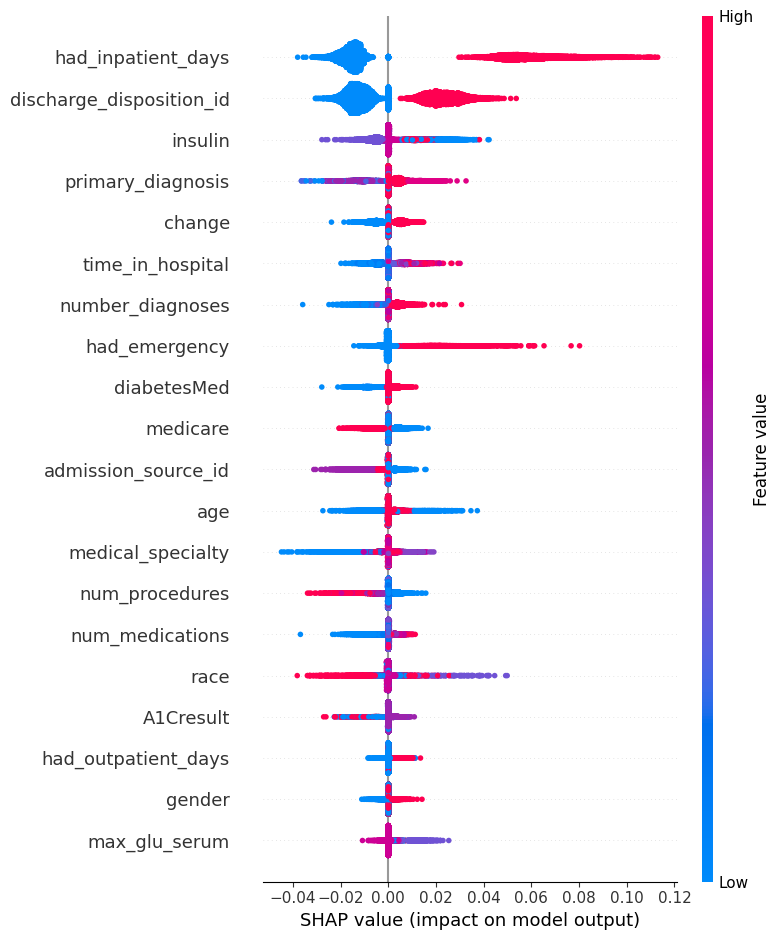

In [ ]:
feature_names = list(num_cols) + list(cat_cols)
shap.summary_plot(shap_values, X_test_combined, feature_names=feature_names)

In [ ]:
with open('saved_shap/fttransformer_shap_values_diabetes.pkl', 'wb') as f:
    pickle.dump(shap_values, f)


## Quantus

### Wrapped Model

In [ ]:
class FTModelWrapper(nn.Module):
    """
    Wraps an FTTransformer so that Quantus can call `.forward(x)` and `.predict(x)`,
    where x is a 2D numpy array of shape (batch_size, n_cont + n_cat). Internally,
    we split into numeric vs. categorical tensors and forward them to the FTTransformer.
    """
    def __init__(self, ft_model: nn.Module, cat_cardinalities):
        super(FTModelWrapper, self).__init__()
        self.model = ft_model
        self.model.eval()
        self.cat_cardinalities = cat_cardinalities  # Store cardinalities for clipping

    def _clip_categorical_indices(self, x_cat):
        """
        Clip categorical indices to valid ranges based on cardinalities.
        """
        x_cat_clipped = x_cat.clone()
        for i, cardinality in enumerate(self.cat_cardinalities):
            # Clip to valid range [0, cardinality-1]
            x_cat_clipped[:, i] = torch.clamp(x_cat_clipped[:, i], 0, cardinality - 1)
        return x_cat_clipped

    def forward(self, combined_x):
        """
        combined_x: torch.Tensor of shape (batch_size, n_cont + n_cat), dtype float or long.
        We'll split it into (X_num, X_cat).
        """
        # split along last dim
        Xn = combined_x[:, :n_cont].float().to(device)
        Xc = combined_x[:, n_cont:].long().to(device)

        # Clip categorical indices to valid ranges
        Xc = self._clip_categorical_indices(Xc)

        logits = self.model(Xn, Xc)  # shape (batch_size, 2)
        return logits

    def predict(self, combined_X):
        """
        combined_X: numpy array of shape (batch_size, n_cont + n_cat).
        Returns: probabilities (batch_size, 2).
        """
        self.model.eval()
        with torch.no_grad():
            # convert to torch
            t = torch.from_numpy(combined_X).float().to(device)
            logits = self.forward(t)  # shape (batch_size, 2)
            probs = torch.softmax(logits, dim=1).cpu().numpy()
        return probs

    def shape_input(self, x: np.ndarray, shape, channel_first):
        """For Quantus: ensure x is at least 2D."""
        return np.atleast_2d(x)

# Update the instantiation to include cardinalities:
wrapped_model = FTModelWrapper(model, cat_cardinalities=cardinalities)
wrapped_model.eval()  # set to eval mode

FTModelWrapper(
  (model): FTTransformer(
    (cls_embedding): _CLSEmbedding()
    (cont_embeddings): LinearEmbeddings()
    (cat_embeddings): CategoricalEmbeddings(
      (embeddings): ModuleList(
        (0): Embedding(6, 32)
        (1): Embedding(2, 32)
        (2): Embedding(3, 32)
        (3): Embedding(2, 32)
        (4): Embedding(3, 32)
        (5): Embedding(6, 32)
        (6): Embedding(5, 32)
        (7-9): 3 x Embedding(4, 32)
        (10-16): 7 x Embedding(2, 32)
      )
    )
    (backbone): FTTransformerBackbone(
      (blocks): ModuleList(
        (0): ModuleDict(
          (attention): MultiheadAttention(
            (W_q): Linear(in_features=32, out_features=32, bias=True)
            (W_k): Linear(in_features=32, out_features=32, bias=True)
            (W_v): Linear(in_features=32, out_features=32, bias=True)
            (dropout): Dropout(p=0.2, inplace=False)
          )
          (attention_residual_dropout): Dropout(p=0.0, inplace=False)
          (ffn_normaliza

### Complexity

In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# 3.1. Complexity (Bhatt et al., 2020) from SHAP attributions
# ──────────────────────────────────────────────────────────────────────────────
Complexity_shap = quantus.Complexity(
    normalise=False,
    abs=True,                 # take absolute values of attributions
    disable_warnings=True,
    display_progressbar=True,
    aggregate_func=np.mean   # mean over all samples
)(
    model=wrapped_model,
    x_batch=X_test_combined,
    y_batch=y_test_int,
    a_batch=shap_values,     # precomputed SHAP values (shape: n_test × (n_cont + n_cat))
    explain_func=None
)

# Scale to [0,1]
Complexity_shap = np.array(Complexity_shap)
Complexity_shap = (Complexity_shap - Complexity_shap.min()) / (Complexity_shap.max() - Complexity_shap.min())
Complexity_shap = float(np.mean(Complexity_shap))

print("Complexity (Bhatt et al., 2020) [SHAP]:", round(Complexity_shap, 4))

  0%|          | 0/319.0 [00:00<?, ?it/s]

Complexity (Bhatt et al., 2020) [SHAP]: 0.7401


In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# 3.2. Sparseness (Chalasani et al., 2020)
# ──────────────────────────────────────────────────────────────────────────────
Sparseness_shap = quantus.Sparseness(
    normalise=False,
    abs=True,
    disable_warnings=True,
    display_progressbar=True,
    return_aggregate=True,    # return a single mean value
    aggregate_func=np.mean
)(
    model=wrapped_model,
    x_batch=X_test_combined,
    y_batch=y_test_int,
    a_batch=shap_values,
    explain_func=None
)

Sparseness_shap = np.array(Sparseness_shap)  # ensure it's a numpy array
Sparseness_shap = float(Sparseness_shap)
print("Sparseness (Chalasani et al., 2020) [SHAP]:", round(Sparseness_shap, 4))

  0%|          | 0/319.0 [00:00<?, ?it/s]

Sparseness (Chalasani et al., 2020) [SHAP]: 0.7583


<ipython-input-22-c3113634dbe3>:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Sparseness_shap = float(Sparseness_shap)


### Faithfulness

In [ ]:

FaithfulnessCorrelation_shap = quantus.FaithfulnessCorrelation(
    perturb_baseline="white",
    perturb_func=quantus.baseline_replacement_by_indices,
    subset_size=5,                           # number of features to perturb per run
    nr_runs=10,                              # how many random subsets to try
    similarity_func=quantus.similarity_func.correlation_pearson,
    abs=True,
    normalise=False,
    return_aggregate=False,                  # get one value per test sample
    aggregate_func=np.mean,
    disable_warnings=True,
    display_progressbar=True,
)(
    model=wrapped_model,
    x_batch=X_test_combined,
    y_batch=y_test_int,
    a_batch=shap_values,
    explain_func=None
)

# scale to [0,1], then take the mean
fc = np.array(FaithfulnessCorrelation_shap)
fc = (fc - np.min(fc)) / (np.max(fc) - np.min(fc))
FaithfulnessCorrelation_shap = float(np.mean(fc))

print("FaithfulnessCorrelation (Bhatt et al., 2020) [SHAP]:", round(FaithfulnessCorrelation_shap, 4))


  0%|          | 0/319.0 [00:00<?, ?it/s]

FaithfulnessCorrelation (Bhatt et al., 2020) [SHAP]: 0.6256


In [ ]:
FaithfulnessEstimate_shap = quantus.FaithfulnessEstimate(
    perturb_baseline="white",
    perturb_func=quantus.baseline_replacement_by_indices,
    features_in_step=1,                      # remove one feature at a time
    similarity_func=quantus.similarity_func.correlation_pearson,
    abs=True,
    normalise=False,
    return_aggregate=False,
    aggregate_func=np.mean,
    disable_warnings=True,
    display_progressbar=True,
)(
    model=wrapped_model,
    x_batch=X_test_combined,
    y_batch=y_test_int,
    a_batch=shap_values,
    explain_func=None,
    device=device,
)

fe = FaithfulnessEstimate_shap
fe = (fe - np.min(fe)) / (np.max(fe) - np.min(fe))
FaithfulnessEstimate_shap = float(np.mean(fe))

print("FaithfulnessEstimate (Alvarez-Melis et al., 2018) [SHAP]:", round(FaithfulnessEstimate_shap, 4))

  0%|          | 0/319.0 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/quantus/helpers/warn.py:257: UserWarning: The settings for perturbing input e.g., 'perturb_func' didn't cause change in input. Reconsider the parameter settings.
  warnings.warn(


FaithfulnessEstimate (Alvarez-Melis et al., 2018) [SHAP]: 0.6488


### Robustness

In [ ]:
LocalLipschitzEstimate_shap = quantus.LocalLipschitzEstimate(
    normalise=False,
    abs=True,
    nr_samples=100,
    disable_warnings=True,
    display_progressbar=True,
    aggregate_func=np.mean
)(
    model=wrapped_model,
    x_batch=X_test_combined,
    y_batch=y_test_int,
    a_batch=None,
    explain_func=quantus.explain,
    explain_func_kwargs={"method": "DeepLift", "reduce_axes": ()},
    device=device,
)

lle = LocalLipschitzEstimate_shap
lle = (lle - np.min(lle)) / (np.max(lle) - np.min(lle))
LocalLipschitzEstimate_shap = float(np.mean(lle))

print("LocalLipschitzEstimate (Alvarez-Melis et al., 2018) [SHAP]:", round(LocalLipschitzEstimate_shap, 4))

  0%|          | 0/319.0 [00:00<?, ?it/s]

LocalLipschitzEstimate (Alvarez-Melis et al., 2018) [SHAP]: 0.0685


### Randomisation

In [ ]:
RandomLogit_shap = quantus.RandomLogit(
    num_classes=2,
    disable_warnings=True,
    normalise=False,
    abs=True,
    display_progressbar=True,
    return_aggregate=True,
    aggregate_func=np.mean
)(
    model=wrapped_model,
    x_batch=X_test_combined,
    y_batch=y_test_int,
    a_batch=None,
    explain_func=quantus.explain,
    explain_func_kwargs={"method": "GradientShap", "reduce_axes": ()},
    device=device,
)

RandomLogit_shap = float(np.array(RandomLogit_shap))
print("RandomLogit (Sixt et al., 2020) [SHAP]:", round(RandomLogit_shap, 4))



  0%|          | 0/319.0 [00:00<?, ?it/s]

RandomLogit (Sixt et al., 2020) [SHAP]: 0.9151


<ipython-input-24-3ec3787a946c>:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  RandomLogit_shap = float(np.array(RandomLogit_shap))


In [ ]:
MPRT_shap = quantus.MPRT(
    return_average_correlation=True,
    layer_order="independent",
    similarity_func=quantus.ssim,
    disable_warnings=True,
    normalise=False,
    abs=True,
    display_progressbar=True,
    aggregate_func=np.mean
)(
    model=wrapped_model,
    x_batch=X_test_combined,
    y_batch=y_test_int,
    a_batch=None,
    explain_func=quantus.explain,
    explain_func_kwargs={"method": "GradientShap", "reduce_axes": ()},
    device=device,
)

mprt = MPRT_shap
mprt = (mprt - np.min(mprt)) / (np.max(mprt) - np.min(mprt))
MPRT_shap = float(np.mean(mprt))

print("MPRT (Adebayo et al., 2018) [SHAP]:", round(MPRT_shap, 4))


  0%|          | 0/854826 [00:00<?, ?it/s]

MPRT (Adebayo et al., 2018) [SHAP]: 0.7078


### Summary

In [ ]:
LocalLipschitzEstimate_shap = 0.0685
RandomLogit_shap = 0.9151
MPRT_shap = 0.7078

In [ ]:
# display(Markdown("#### Explanability scores"))

print("Complexity:", round((Complexity_shap + Sparseness_shap) / 2, 4))
print("Faithfulness:", round((FaithfulnessEstimate_shap + FaithfulnessCorrelation_shap) / 2, 4))
print("Robustness:", round(LocalLipschitzEstimate_shap, 4))
print("Randomisation:", round((MPRT_shap + RandomLogit_shap) / 2, 4))

Complexity: 0.7492
Faithfulness: 0.6372
Robustness: 0.0685
Randomisation: 0.8115


# Sustainability

## Param Count

In [ ]:
# Parameter Count (Pure PyTorch)
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Usage
total_params = count_parameters(model)
print(f"Trainable parameters: {total_params:,}")

Trainable parameters: 24,990


## FLOPs

In [ ]:
# Calculate FLOPS
from torch.utils.flop_counter import FlopCounterMode

X_test_num_torch = torch.from_numpy(X_test_num).to(device)    # float32 tensor, shape (n_test, n_cont)
X_test_cat_torch = torch.from_numpy(X_test_cat).to(device)

sample_num    = X_test_num_torch[0:1]  # shape (1, n_cont)
sample_cat    = X_test_cat_torch[0:1]  # shape (1, n_cat)

model.eval()
with FlopCounterMode() as flop_counter:
    _ = model(sample_num, sample_cat)

flops_per_sample = flop_counter.get_total_flops()
print(f"FLOPs per sample: {flops_per_sample/1e3:.2f} K")
print(f"FLOPs: {flops_per_sample*X_test_num_torch.shape[0]/1e6:.2f}M")

Module                        FLOP    % Total
-----------------------  ---------  ---------
FTTransformer            1073.792K    100.00%
 - aten.addmm             935.424K     87.11%
 - aten.bmm               138.368K     12.89%
 FTTransformer.backbone  1073.792K    100.00%
  - aten.addmm            935.424K     87.11%
  - aten.bmm              138.368K     12.89%
FLOPs per sample: 1073.79 K
FLOPs: 21854.89M


## MACs

In [ ]:
n_cont = X_test_num.shape[1]
n_cat  = X_test_cat.shape[1]
cat_cardinalities = cardinalities  # list of ints, one per categorical column

class FTTransformerSingleInput(nn.Module):
    def __init__(self, ft_model, n_cont, n_cat, cat_cardinalities):
        super().__init__()
        self.ft = ft_model
        self.n_cont = n_cont
        self.n_cat = n_cat
        self.cat_cardinalities = cat_cardinalities

    def forward(self, x_combined):
        x_num = x_combined[:, : self.n_cont].float()
        x_cat = x_combined[:, self.n_cont : self.n_cont + self.n_cat].long()
        # Clip to valid category range:
        for i, card in enumerate(self.cat_cardinalities):
            x_cat[:, i] = torch.clamp(x_cat[:, i], 0, card - 1)
        return self.ft(x_num, x_cat)

wrapped = FTTransformerSingleInput(model, n_cont, n_cat, cat_cardinalities)
wrapped.to(device)
wrapped.eval()

FTTransformerSingleInput(
  (ft): FTTransformer(
    (cls_embedding): _CLSEmbedding()
    (cont_embeddings): LinearEmbeddings()
    (cat_embeddings): CategoricalEmbeddings(
      (embeddings): ModuleList(
        (0): Embedding(6, 32)
        (1): Embedding(2, 32)
        (2): Embedding(3, 32)
        (3): Embedding(2, 32)
        (4): Embedding(3, 32)
        (5): Embedding(6, 32)
        (6): Embedding(5, 32)
        (7-9): 3 x Embedding(4, 32)
        (10-16): 7 x Embedding(2, 32)
      )
    )
    (backbone): FTTransformerBackbone(
      (blocks): ModuleList(
        (0): ModuleDict(
          (attention): MultiheadAttention(
            (W_q): Linear(in_features=32, out_features=32, bias=True)
            (W_k): Linear(in_features=32, out_features=32, bias=True)
            (W_v): Linear(in_features=32, out_features=32, bias=True)
            (dropout): Dropout(p=0.2, inplace=False)
          )
          (attention_residual_dropout): Dropout(p=0.0, inplace=False)
          (ffn_no

In [ ]:
from ptflops import get_model_complexity_info

input_shape = (n_cont + n_cat,)
with torch.cuda.device(0):
    macs_str, params_str = get_model_complexity_info(
        wrapped,
        input_shape,
        as_strings=True,
        print_per_layer_stat=True,
        verbose=True,
    )

print(f"MACs per sample (string): {macs_str}")
print(f"Params (string)      : {params_str}")

# Parse the MACs string into a float (number of multiply-adds per sample)
def parse_macs_str(s):
    if s.endswith(" GMac"):
        return float(s.replace(" GMac", "")) * 1e9
    if s.endswith(" MMac"):
        return float(s.replace(" MMac", "")) * 1e6
    if s.endswith(" KMac"):
        return float(s.replace(" KMac", "")) * 1e3
    if s.endswith(" Mac"):
        return float(s.replace(" Mac", ""))
    raise ValueError(f"Unrecognized MACs format: {s}")

macs_per_sample = parse_macs_str(macs_str)
print(f"MACs per sample: {macs_per_sample/1e3:.2f} K")
total_macs = macs_per_sample * X_test_num.shape[0]
print(f"MACs: {total_macs/1e6:.2f} M")

FTTransformerSingleInput(
  22.4 k, 89.628% Params, 485.38 KMac, 99.180% MACs, 
  (ft): FTTransformer(
    22.4 k, 89.628% Params, 485.38 KMac, 99.180% MACs, 
    (cls_embedding): _CLSEmbedding(0, 0.000% Params, 0.0 Mac, 0.000% MACs, )
    (cont_embeddings): LinearEmbeddings(0, 0.000% Params, 0.0 Mac, 0.000% MACs, )
    (cat_embeddings): CategoricalEmbeddings(
      0, 0.000% Params, 0.0 Mac, 0.000% MACs, 
      (embeddings): ModuleList(
        (0): Embedding(0, 0.000% Params, 0.0 Mac, 0.000% MACs, 6, 32)
        (1): Embedding(0, 0.000% Params, 0.0 Mac, 0.000% MACs, 2, 32)
        (2): Embedding(0, 0.000% Params, 0.0 Mac, 0.000% MACs, 3, 32)
        (3): Embedding(0, 0.000% Params, 0.0 Mac, 0.000% MACs, 2, 32)
        (4): Embedding(0, 0.000% Params, 0.0 Mac, 0.000% MACs, 3, 32)
        (5): Embedding(0, 0.000% Params, 0.0 Mac, 0.000% MACs, 6, 32)
        (6): Embedding(0, 0.000% Params, 0.0 Mac, 0.000% MACs, 5, 32)
        (7-9): 3 x Embedding(0, 0.000% Params, 0.0 Mac, 0.000% MACs,

## kgCO2e

In [ ]:
def compute_kgco2e(pc: float, pg: float, time_hours: float):
    """
    Compute kgCO2 emission, and normalized emission per capita.
    Args:
        pc: average CPU power in watts
        pg: average GPU power in watts
        time_hours: training + eval time in hours

    Returns:
        tuple: CO2e (kg), normalized CO2e
    """
    pt = (pc + pg) * time_hours / 1000  # power in kWh
    co2e = 0.498 * pt  # Germany's emission rate
    normalized = co2e / 26  # per-capita daily emission baseline

    return co2e, normalized

In [ ]:
"""
Intel(R) Xeon(R) CPU @ 2.20GHz
Model: 79 (
-> Intel Xeon E5-2673 v4 from the Broadwell-EP family - specifications:
    Cores: 10
    Threads: 20
    Base Frequency: 2.3 GHz
    Maximum Turbo Speed: 3.5 GHz
    Cache: 50 MB
    TDP: 135W

Colab uses 2 vCPUs (each 1 core -> total 2 cores out of 20)
-> only use 10% of the actuall TDP -> 13.5 W
"""
pc = 13.5
pg = 70

In [ ]:
elapsed_time = elapsed_time / 3600
kgco2e, kgco2e_normalized = compute_kgco2e(pc, pg, elapsed_time)

print(f"kgCO2 emission: {kgco2e:.4f} kg")
print(f"Normalized kgCO2 emission: {kgco2e_normalized:.4f}")

kgCO2 emission: 0.0185 kg
Normalized kgCO2 emission: 0.0007
